In [4]:
from lib.models import ResNet
from lib.datasets import Dataset2p0
from torch.utils.data import DataLoader
import torch
from torch import nn
from tqdm import tqdm
from lib.utils import cms,test_evaluation
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset,DataLoader
import plotly.express as px
import pandas as pd
from lib.utils import get_bout_statistics_for_predictions
import numpy as np
device = 'cuda'
model = ResNet(n_features=15000).to(device)

params = sum([p.flatten().size()[0] for p in list(model.parameters())])
print("Params: ",params)
data_dir = 'w3'
trainloader = DataLoader(Dataset2p0(dir=f'{data_dir}/train/',labels=f'{data_dir}/y_train.pt'),batch_size=64,shuffle=True)
devloader = DataLoader(Dataset2p0(dir=f'{data_dir}/dev/',labels=f'{data_dir}/y_dev.pt'),batch_size=64,shuffle=True)
testloader = DataLoader(Dataset2p0(dir=f'{data_dir}/test/',labels=f'{data_dir}/y_test.pt'),batch_size=64,shuffle=True)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

Params:  8187


In [13]:
lossi = []

In [24]:
model.train()
for i in range(5):
    for (X_tr,y_tr) in tqdm(trainloader):
        X_tr,y_tr = X_tr.to(device),y_tr.to(device)
        logits = model(X_tr)
        loss = criterion(logits,y_tr)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lossi.append(loss.item())

100%|██████████| 1821/1821 [02:00<00:00, 15.06it/s]


tensor(0.3013)


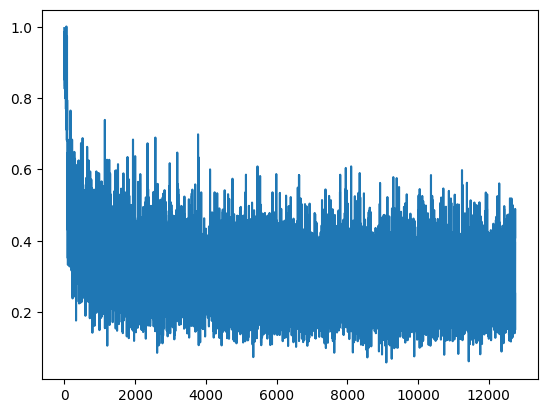

In [25]:
plt.plot(lossi)
print(torch.tensor(lossi).mean())

tensor(0.2266)


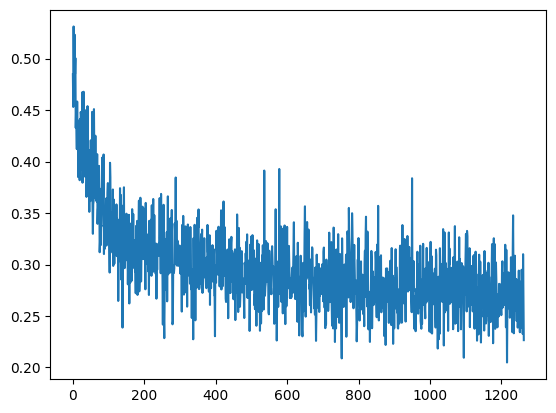

In [26]:
plt.plot(torch.tensor(lossi[100:len(lossi) - len(lossi)%10]).view(-1,10).mean(axis=1))
print(torch.tensor(lossi[100:len(lossi) - len(lossi)%10]).view(-1,10).mean(axis=1)[-1])

100%|██████████| 1821/1821 [00:52<00:00, 34.86it/s]


(0.2753548588785806,
 tensor([2., 2., 1.,  ..., 1., 1., 2.]),
 tensor([2., 2., 1.,  ..., 1., 1., 2.]))

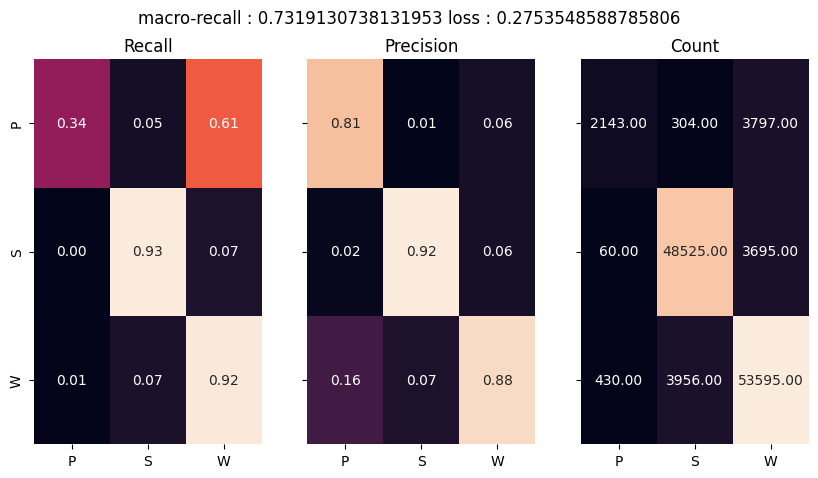

In [27]:
test_evaluation(trainloader,model,criterion)
#.275

100%|██████████| 911/911 [00:26<00:00, 34.95it/s]


(0.2801877501963522,
 tensor([2., 2., 2.,  ..., 1., 2., 1.]),
 tensor([2., 2., 2.,  ..., 1., 2., 1.]))

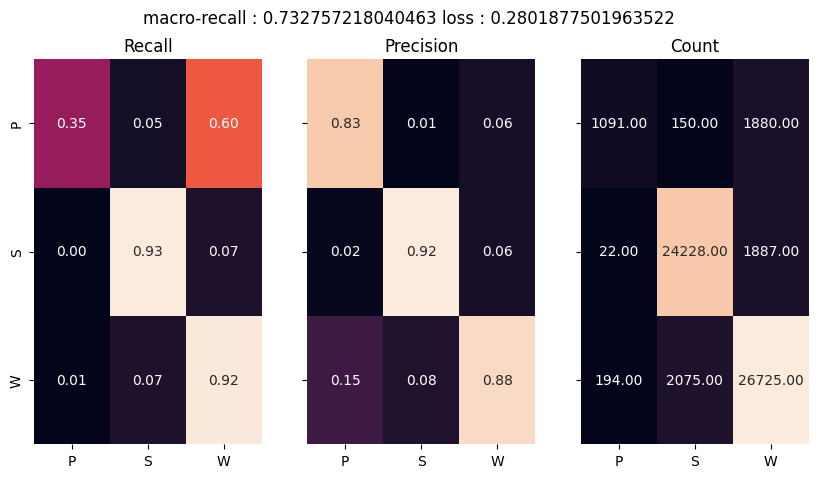

In [28]:
test_evaluation(devloader,model,criterion)
#.280

100%|██████████| 135/135 [00:01<00:00, 122.98it/s]


Experting


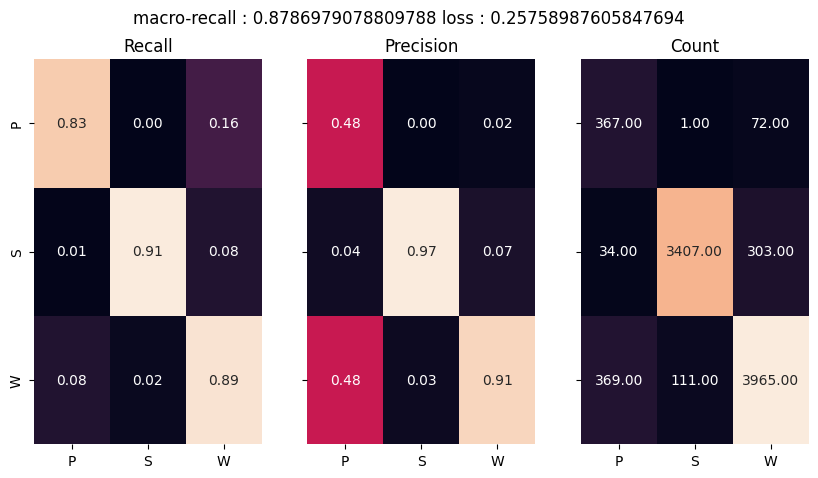

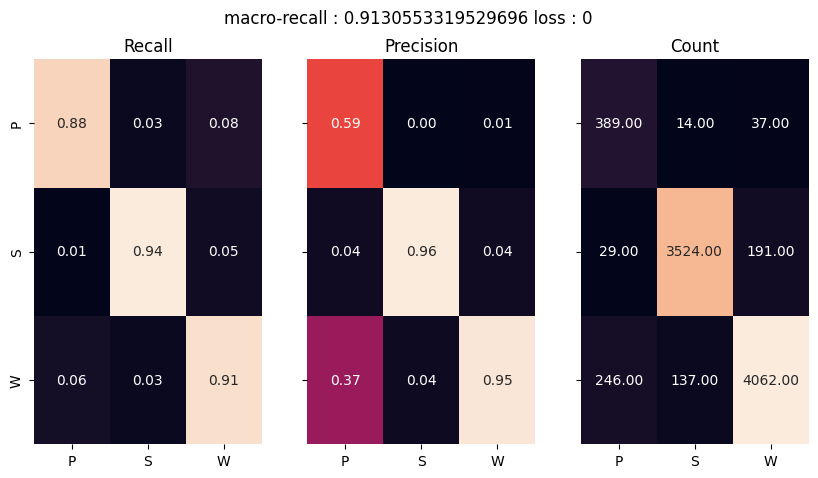

In [56]:
# evaluate single holdout
X,y = torch.load(f'{data_dir}/holdout_14.pt')
holdoutloader = DataLoader(TensorDataset(X,y),batch_size=64)
loss,y_true,y_pred = test_evaluation(holdoutloader,model,criterion)
pred_expert = np.array(y_pred).copy()
print("Experting")

for j in range(len(pred_expert)-2):
    if(pred_expert[j+1] != pred_expert[j] and pred_expert[j+1] != pred_expert[j+2]):
        pred_expert[j+1] = pred_expert[j]
df = pd.DataFrame([y_true.numpy(),y_pred.detach().cpu().numpy(),pred_expert],index=['true','pred','expert']).T

df.loc[df['true'] == 2,'true'] = 'W'
df.loc[df['true'] == 1,'true'] = 'S'
df.loc[df['true'] == 0,'true'] = 'P'
df.loc[df['pred'] == 2,'pred'] = 'W'
df.loc[df['pred'] == 1,'pred'] = 'S'
df.loc[df['pred'] == 0,'pred'] = 'P'
df.loc[df['expert'] == 2,'expert'] = 'W'
df.loc[df['expert'] == 1,'expert'] = 'S'
df.loc[df['expert'] == 0,'expert'] = 'P'
cms(y_true=y_true,y_pred=pred_expert)

In [57]:
get_bout_statistics_for_predictions(df['true'])

,P,S,W
total,73.333333,624.000000,740.833333
average,70.967742,229.693252,296.333333
counts,62.000000,163.000000,150.000000


In [59]:
get_bout_statistics_for_predictions(df['expert'])

,P,S,W
total,110.666667,612.500000,715.000000
average,61.481481,186.548223,180.252101
counts,108.000000,197.000000,238.000000


In [55]:
fig = px.line(data_frame=df,y=['true','pred'])
fig.show(renderer='browser')

In [ ]:
# # evaluate single holdout
# from sklearn.metrics import recall_score,precision_score,f1_score

# holdout_idx = [4,5,7,14,30]
# recalls = []
# precisions = []
# f1s = []
# for idx in holdout_idx:
#     X,y = torch.load(f'{data_dir}/holdout_{idx}.pt')
#     holdoutloader = DataLoader(TensorDataset(X,y),batch_size=64)
#     loss,y_true,y_pred = test_evaluation(holdoutloader,model,criterion)
#     recall = recall_score(y_true=y_true,y_pred=y_pred,average='macro')
#     precision = precision_score(y_true=y_true,y_pred=y_pred,average='macro')
#     f1 = f1_score(y_true=y_true,y_pred=y_pred,average='macro')
#     recalls.append(recall)
#     precisions.append(precision)
#     f1s.append(f1)
#     print(recall,precision,f1,idx)
# import seaborn as sns
# sns.kdeplot(recalls)
# sns.kdeplot(precisions)
# sns.kdeplot(f1s)
# torch.tensor(f1s).mean()
# torch.tensor(f1s).std()